<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/ARIMA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U statsmodels

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!head /content/airline_passengers.csv

"Month","Passengers"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129
"1949-05",121
"1949-06",135
"1949-07",148
"1949-08",148
"1949-09",136


In [5]:
df = pd.read_csv("/content/airline_passengers.csv",index_col = "Month",parse_dates = True)

In [6]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Month'>

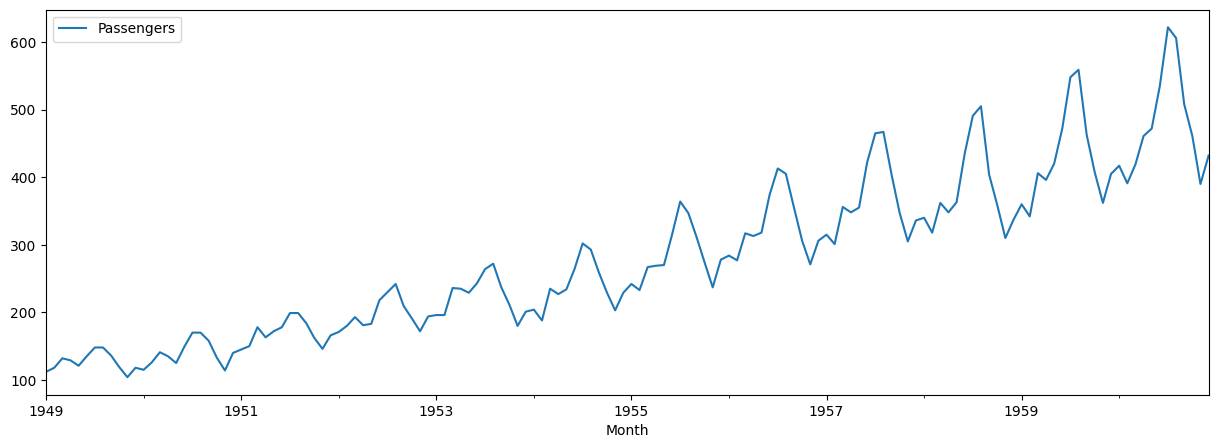

In [7]:
df.plot(figsize = (15,5))

In [8]:
df['1stdiff'] = df['Passengers'].diff()

In [14]:
df = df.rename(columns = {'Passengers':'passenger'})

In [15]:
df.head()

,passenger,1stdiff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


<Axes: xlabel='Month'>

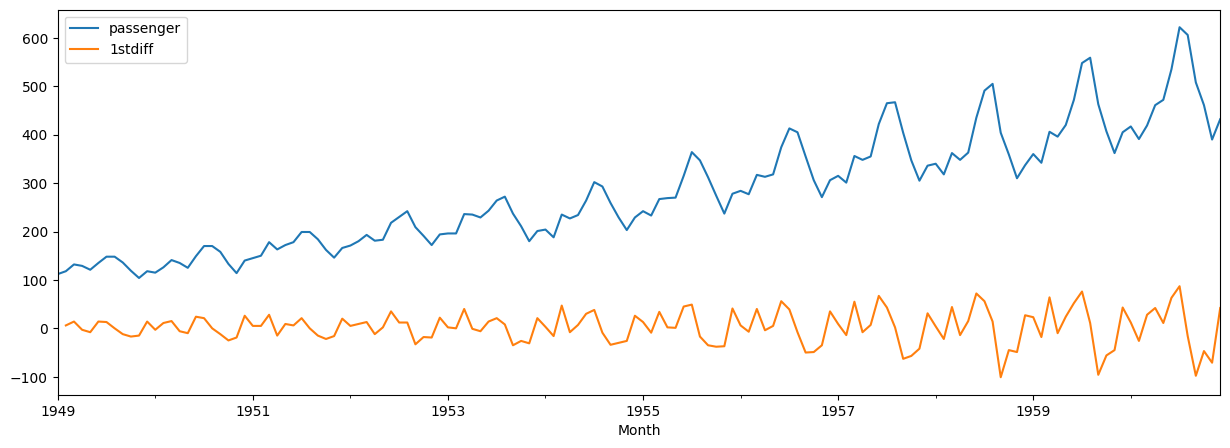

In [17]:
#Is not quite stationary, having some seasonality
df.plot(figsize = (15,5))

In [18]:
df['LogPassenger'] = np.log(df['passenger'])

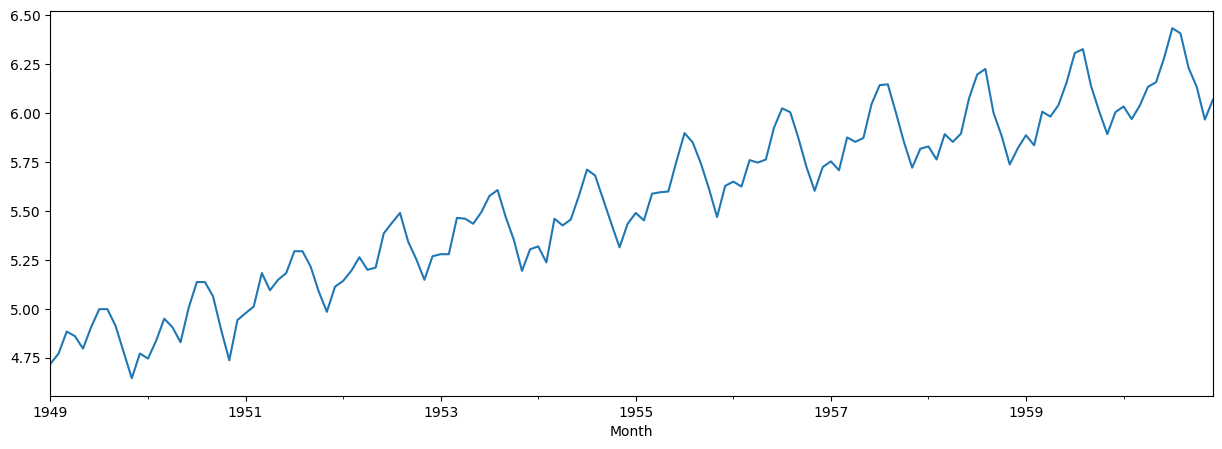

In [21]:
#The amplitude of the cycle looks more constant
df['LogPassenger'].plot(figsize = (15,5));

In [22]:
from statsmodels.tsa.arima.model import ARIMA

In [25]:
df.index.freq = 'MS'

In [26]:
NTest = 12

train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [27]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [30]:
arima = ARIMA(train['passenger'],order = (1,0,0))

In [31]:
arima_result = arima.fit()

In [32]:
df.loc[train_idx,'AR(1)'] = arima_result.predict(
    start = train.index[0],end = train.index[-1]
)

<Axes: xlabel='Month'>

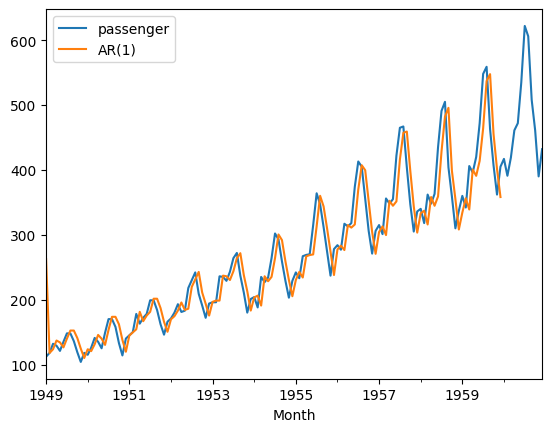

In [34]:
df[['passenger','AR(1)']].plot()

In [35]:
prediction_result = arima_result.get_forecast(NTest)
forecast = prediction_result.predicted_mean
df.loc[test_idx,'AR(1)'] = forecast

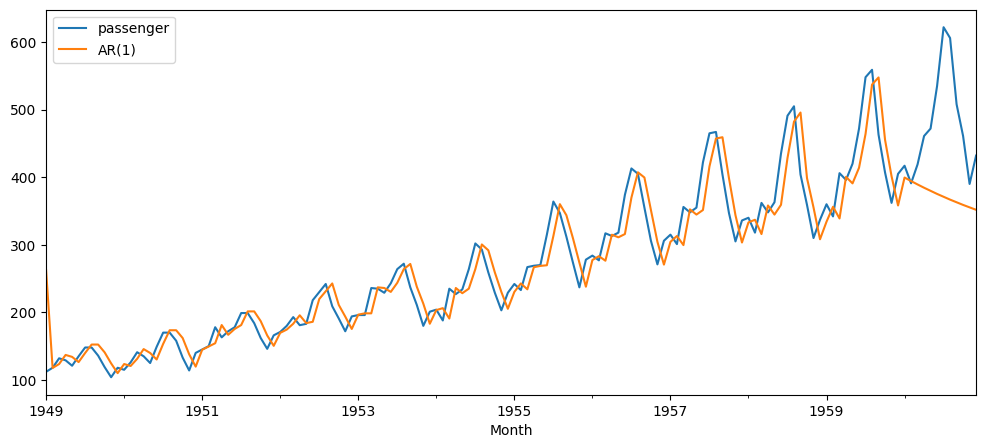

In [37]:
df[['passenger','AR(1)']].plot(figsize = (12,5));

In [42]:
#Confidence interval
prediction_result.conf_int()

,lower passenger,upper passenger
1960-01-01,338.658210,460.451500
1960-02-01,309.826171,478.809354
1960-03-01,287.732168,490.829379
1960-04-01,269.338256,499.534230
1960-05-01,253.432284,506.121347
1960-06-01,239.373402,511.217437
1960-07-01,226.768868,515.201638
1960-08-01,215.354570,518.324977
1960-09-01,204.941150,520.764224
1960-10-01,195.386337,522.649550


In [53]:
def plot_fit_and_forecast(result):
  fig,ax = plt.subplots(figsize = (15,5))
  ax.plot(df['passenger'],label = 'data')

  #Plot the curve fitted on train set
  train_pred = result.fittedvalues
  ax.plot(train.index,train_pred,color = 'green',label = 'fitted')

  #forecast the test set
  prediction_result = result.get_forecast(NTest)
  conf_int = prediction_result.conf_int()
  lower,upper = conf_int['lower passenger'],conf_int['upper passenger']
  forecast = prediction_result.predicted_mean
  ax.plot(test.index,forecast,label = 'forecast')
  ax.fill_between(test.index,\
                  lower,upper, \
                  color = 'red', \
                  alpha = 0.3)
  ax.legend()

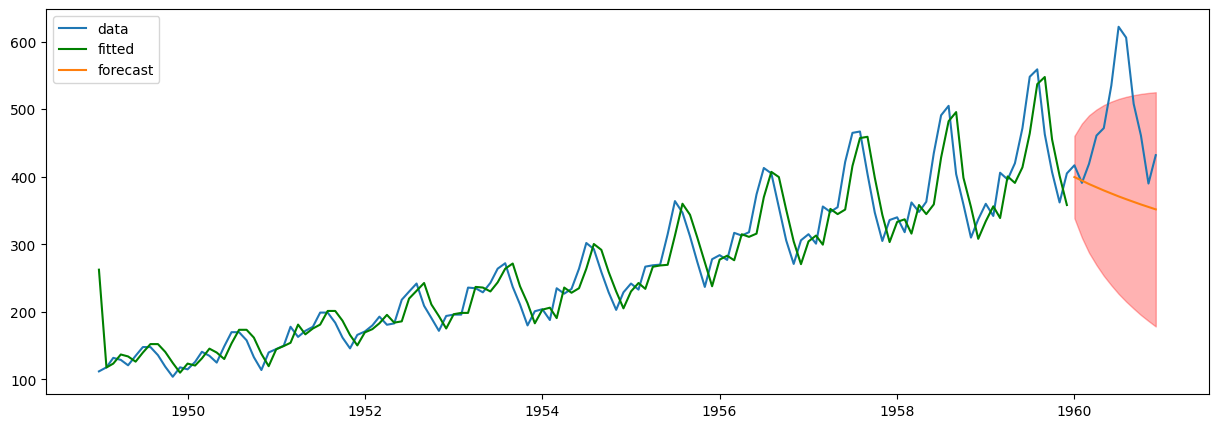

In [54]:
plot_fit_and_forecast(arima_result)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


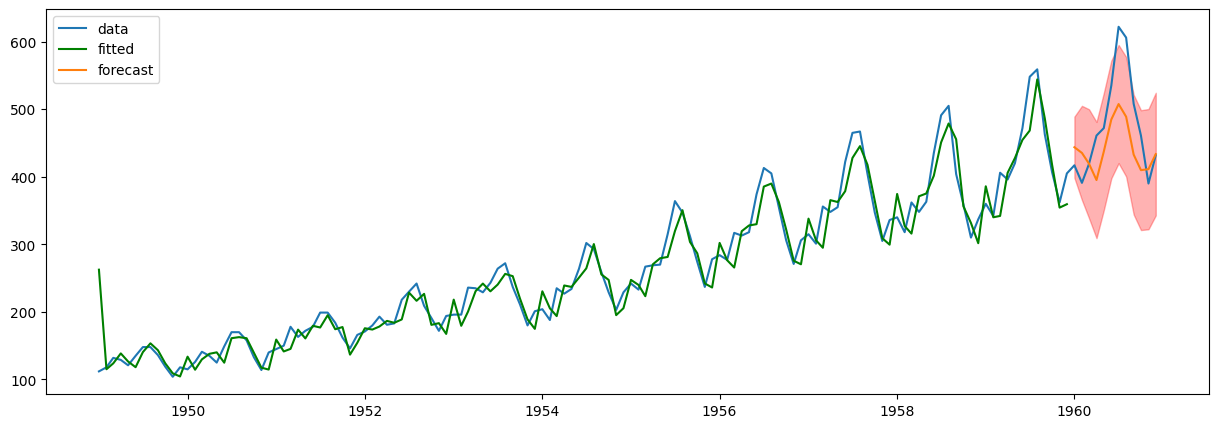

In [58]:
arima = ARIMA(train['passenger'],order = (10,0,0)) #AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


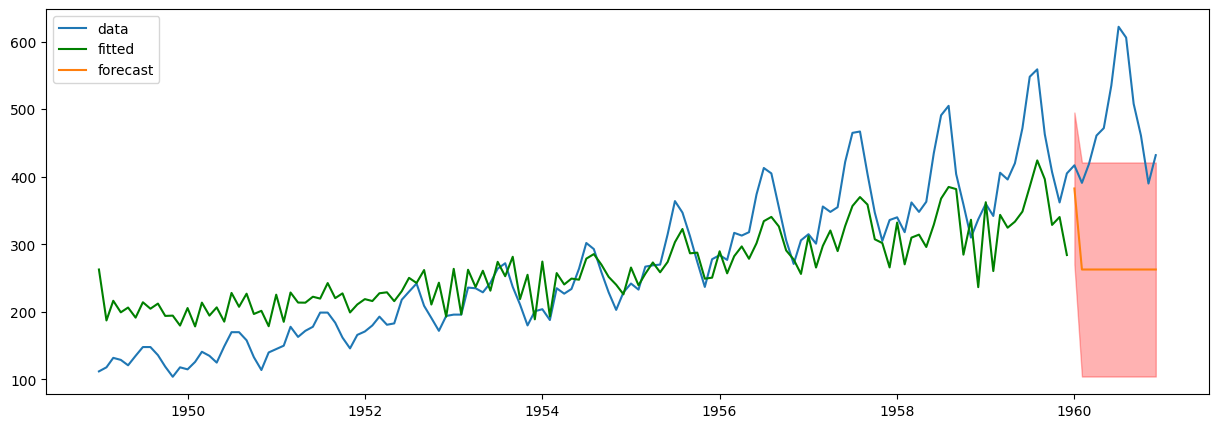

In [59]:
arima = ARIMA(train['passenger'],order = (0,0,1))
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)